## Exercises
1. The end result of this exercise should be a Jupyter notebook named model.
2. Using saas.csv or log data from API usage or store_item_sales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from datetime import timedelta, datetime
from time import strftime
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

import acquire, prepare

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

In [3]:
# Load saas data

df = pd.read_csv('saas.csv')

# Print the shape
print(df.shape)

df.head()

(790458, 5)


,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
# Any missing values?
df.isna().sum().sum()

0

In [5]:
# How many unique customer_ids
df.Customer_Id.value_counts().size # 29400 unique customer_ids

29400

In [6]:
# How many unique invoice_ids?
df.Invoice_Id.value_counts().size # 790458 unique invoice_ids so invoice_id is unique

790458

In [7]:
# How many unique subscription_type?
df.Subscription_Type.value_counts() # 5 unique subscription types so subscription_type is the categorical

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: Subscription_Type, dtype: int64

**Takeaways**
1. change the column names to lower case. 
2. set the date column to index
3. no missing values

In [8]:
# Create a function to process the data

def prep_data(df):
    df.columns = [col.lower() for col in df.columns] # Convert column names to lower case
    df.month_invoiced = pd.to_datetime(df.month_invoiced)
    df = df.set_index('month_invoiced').sort_index()
    df = pd.DataFrame(df.resample('M').amount.sum())
    return df

In [9]:
# Preprocess the df

df = prep_data(df)
df.shape

(48, 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-31 to 2017-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [11]:
# Quick check the processed data
df.tail()

,amount
month_invoiced,
2017-08-31,53820.0
2017-09-30,53925.0
2017-10-31,53850.0
2017-11-30,53860.0
2017-12-31,53805.0


In [12]:
# Check the index
print(df.index.dtype) # in the datetime format

datetime64[ns]


In [13]:
# Summarize the df
print('Date Range:', df.index.min(), 'to', df.index.max()) # From Jan 2014 to 2017 (whole year)

Date Range: 2014-01-31 00:00:00 to 2017-12-31 00:00:00


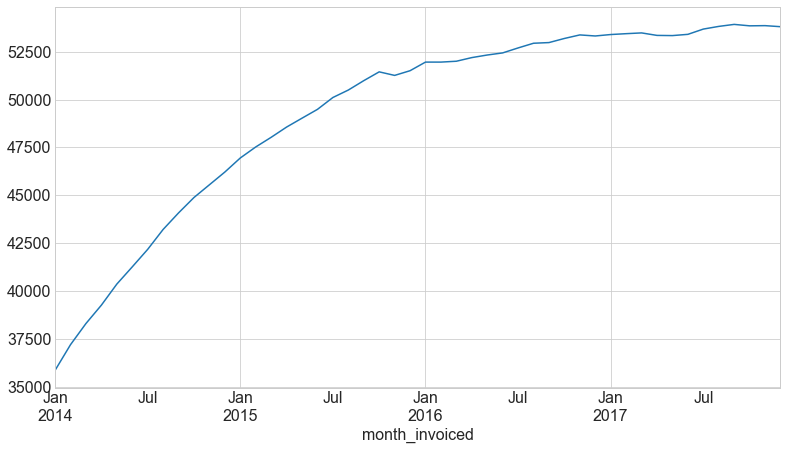

In [14]:
# Plot the amout over time
df.amount.plot()

### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [15]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

validate_end_index

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

### Verify Splits

In [16]:
# Does the length of each df equate to the length of the original df?
print(len(train) + len(validate) + len(test) == len(df))

True


In [17]:
# Does the first row of original df equate to the first row of train?
print(df.head(1) == train.head(1))

                amount
month_invoiced        
2014-01-31        True


In [18]:
# Is the last row of train the day before the first row of validate? 
pd.concat([train.tail(1), validate.head(1)])

,amount
month_invoiced,
2015-12-31,51505.0
2016-01-31,51955.0


In [19]:
# And the same for validate to test?
pd.concat([validate.tail(1), test.head(1)])

,amount
month_invoiced,
2017-02-28,53440.0
2017-03-31,53480.0


In [20]:
# Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), df.tail(1)])

,amount
month_invoiced,
2017-12-31,53805.0
2017-12-31,53805.0


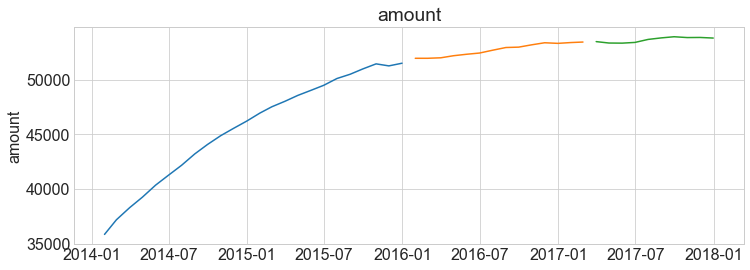

In [21]:
# Let's plot our data first, viewing where the data is split into train and test.

for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [22]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [23]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [24]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [25]:
eval_df

,model_type,target_var,rmse


### Forecast: Last ovserved value (based on previous month)

In [26]:
# Make predictions

amount = round(train['amount'][-1:][0], 2)
amount

51505.0

In [27]:
yhat_df = pd.DataFrame({'amount': amount}, index = validate.index)

yhat_df.head(2) # You can see, when peeking into yhat_df, that every predicted value is the same.

,amount
month_invoiced,
2016-01-31,51505.0
2016-02-29,51505.0


amount -- RMSE: 1343


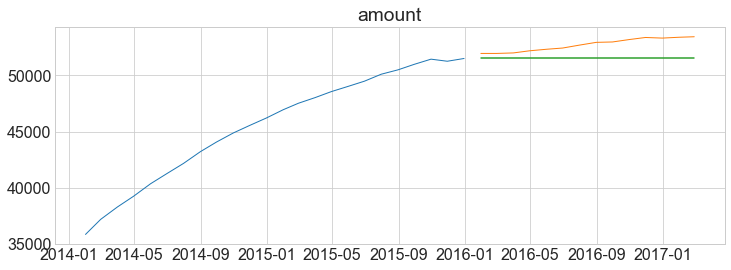

In [28]:
# Plot actual vs. predicted values

for col in train.columns:
    plot_and_eval(col)

In [29]:
# Evaluate

for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0


### Forecast: simple average

In [30]:
# Make predictions

amount = round(train['amount'].mean(), 2)
amount

45568.54

In [31]:
def make_predictions():
    yhat_df = pd.DataFrame({'amount': [amount]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()
yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,45568.54
2016-02-29,45568.54


amount -- RMSE: 7181


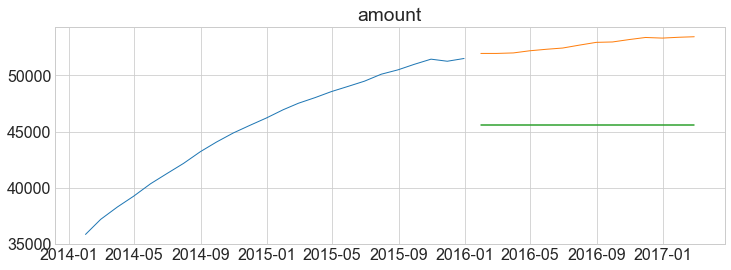

In [32]:
# Plot actual vs. predicted values

for col in train.columns:
    plot_and_eval(col)

In [33]:
# Evaluate

for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple average', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple average,amount,7181.0


### Forecast - Moving Average

In [34]:
train['amount'].tail(2).mean()

51382.5

In [35]:
train['amount'].rolling(2).mean().tail()

month_invoiced
2015-08-31    50300.0
2015-09-30    50740.0
2015-10-31    51215.0
2015-11-30    51352.5
2015-12-31    51382.5
Freq: M, Name: amount, dtype: float64

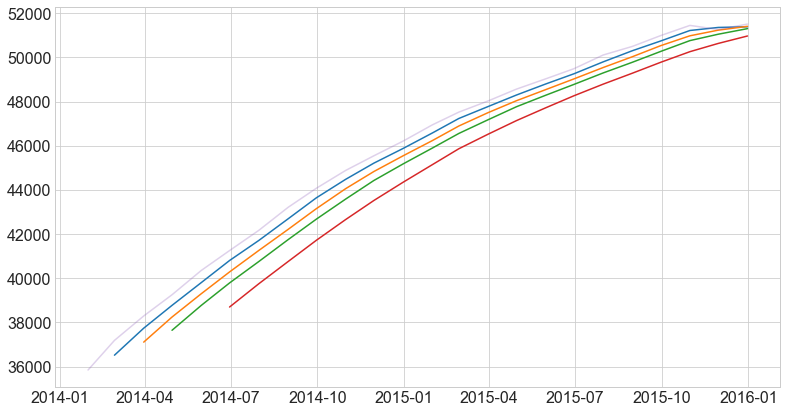

In [36]:
plt.figure(figsize=(13,7))
plt.plot(train['amount'].rolling(2).mean())
plt.plot(train['amount'].rolling(3).mean())
plt.plot(train['amount'].rolling(4).mean())
plt.plot(train['amount'].rolling(6).mean())
plt.plot(train['amount'], alpha=.3)

In [37]:
# Make predictions

period = 2

amount = round(train['amount'].rolling(period).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,amount
month_invoiced,
2016-01-31,51382.5
2016-02-29,51382.5
2016-03-31,51382.5


amount -- RMSE: 1455


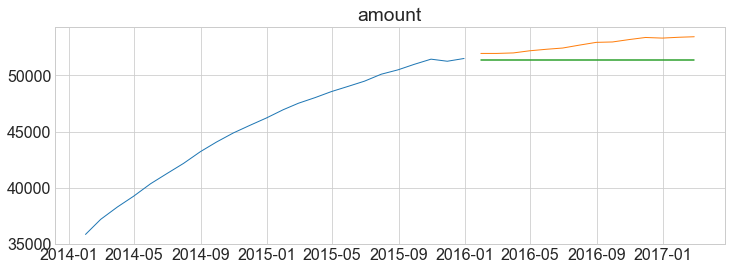

In [38]:
# Plot actual vs. predicted values

for col in train.columns:
    plot_and_eval(col)

In [39]:
# Evaluate

for col in train.columns:
    eval_df = append_eval_df(model_type='2m moving average', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple average,amount,7181.0
2,2m moving average,amount,1455.0


### Holt's Linear Trend

amount 



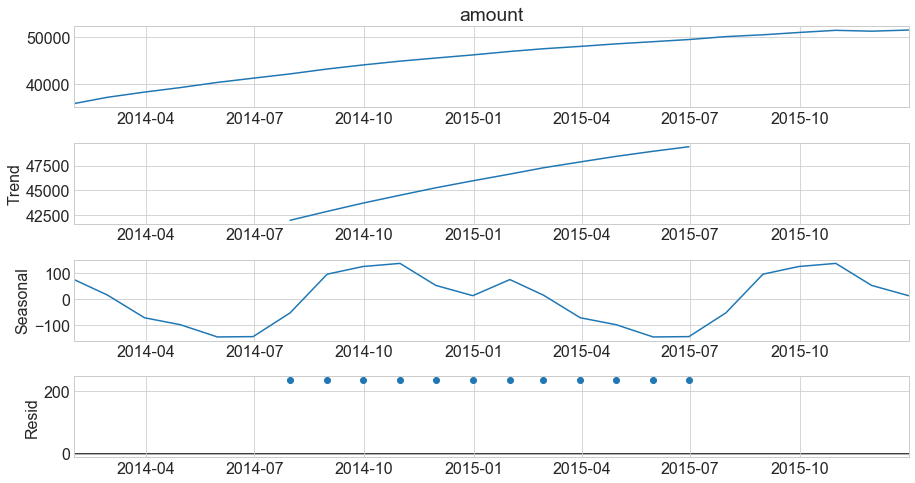

In [40]:
# Take a look at the seasonal decomposition

import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
    plt.show()

In [41]:
# Make prediction

for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(optimized = True)
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat, 2)

amount -- RMSE: 603


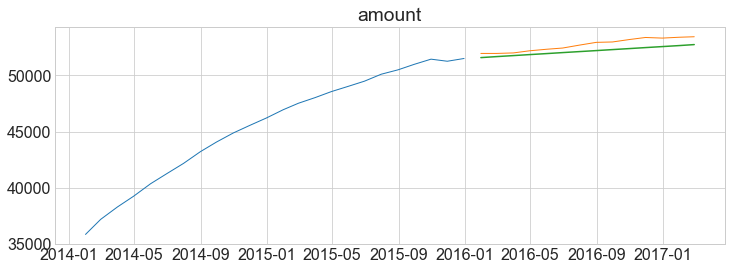

In [42]:
# Plot Actual vs. predicted values

for col in train.columns:
    plot_and_eval(target_var = col)

In [43]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_optimized', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple average,amount,7181.0
2,2m moving average,amount,1455.0
3,Holts_optimized,amount,603.0


In [44]:
# Let's do anonther model, changing some hyperparameters

for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])
    yhat_df[col] = round(yhat, 2)

amount -- RMSE: 8103


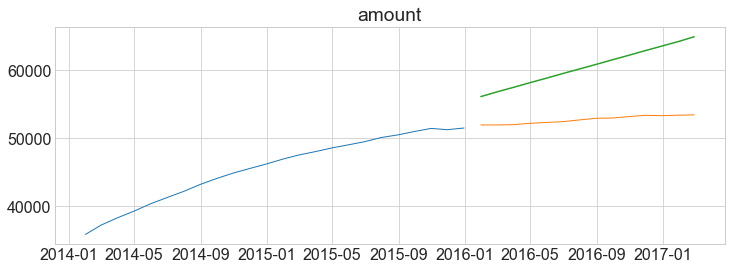

In [45]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts_smoothing', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,1343.0
1,simple average,amount,7181.0
2,2m moving average,amount,1455.0
3,Holts_optimized,amount,603.0
4,Holts_smoothing,amount,8103.0


### Predict Based on Previous Cycle

In [47]:
# Re-split data

train = df[:'2015']
validate = df['2016']
test = df['2017']

In [48]:
# Make Predictions

yhat_df = train['2015'] + train.diff(12).mean()

In [49]:
# Take a peek into the prediction we will make for 1/31/16

pd.concat([yhat_df.head(1), validate.head(1)])

,amount
month_invoiced,
2015-01-31,55033.75
2016-01-31,51955.00


In [50]:
# set yhat_df to index of validate

yhat_df.index = validate.index
len(yhat_df)

12

amount -- RMSE: 5192


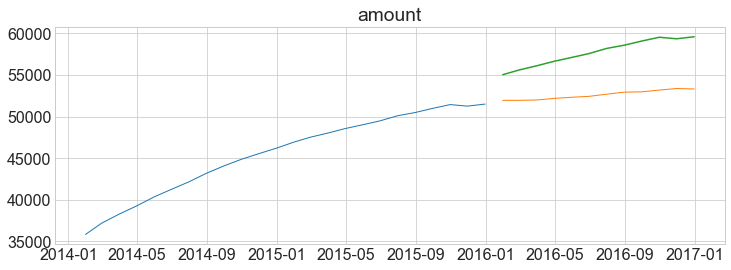

In [53]:
# Plot and evaluate

for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

In [54]:
# Which model is the best? 

eval_df.sort_values(by='rmse') # Holts-optimized

,model_type,target_var,rmse
3,Holts_optimized,amount,603.0
0,last_observed_value,amount,1343.0
2,2m moving average,amount,1455.0
5,previous year,amount,5192.0
6,previous year,amount,5192.0
1,simple average,amount,7181.0
4,Holts_smoothing,amount,8103.0


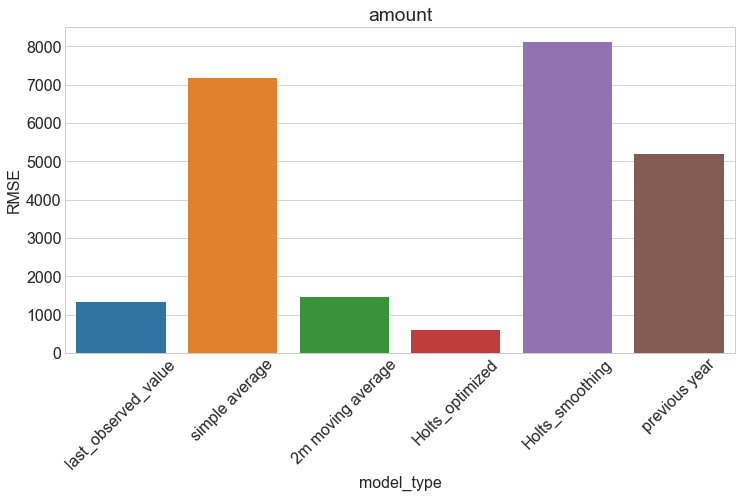

In [55]:
# Which model is the best?

for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()  # Holts_optimized

### Test 
- We will use train + validate to predict test

In [56]:
# Redo the split data by percentage

train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [57]:
test.index[-1]

Timestamp('2017-12-31 00:00:00', freq='M')

In [58]:
# Append validate to train

train_validate = train.append(validate)
train_validate

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [59]:
# Reset yhat_df

yhat_df = pd.DataFrame()
print(yhat_df)

for col in train.columns:
    model = Holt(train_validate[col], exponential = False)
    model = model.fit(optimized = True)
    yhat = model.predict(start = test.index[0], end = test.index[-1])
    yhat_df[col] = round(yhat, 2)

Empty DataFrame
Columns: []
Index: []


In [60]:
# Compatre yhat_df and test

pd.concat([yhat_df, test], axis=1)

,amount,amount
2017-03-31,53477.24,53480.0
2017-04-30,53510.27,53350.0
2017-05-31,53543.30,53340.0
2017-06-30,53576.33,53405.0
2017-07-31,53609.36,53680.0
2017-08-31,53642.40,53820.0
2017-09-30,53675.43,53925.0
2017-10-31,53708.46,53850.0
2017-11-30,53741.49,53860.0
2017-12-31,53774.52,53805.0


In [61]:
rmse_amount = round(sqrt(mean_squared_error(test['amount'], yhat_df['amount'])), 0)

In [62]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

rmse - amount: 152.0


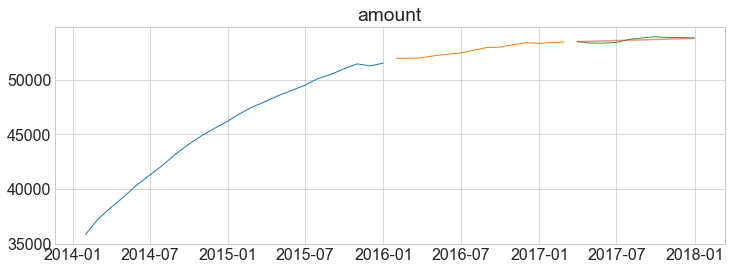

In [63]:
print("rmse - amount:", rmse_amount)

for col in train.columns:
    plot_and_eval(target_var = col)